# TP1: Spectral and Temporal Modifications

*By Daniel Deutsch and Kevin Kühl*

In [1]:
import wave

import matplotlib.pyplot as plt
import numpy as np
import pyaudio
import scipy.signal as sig
from scipy.signal.windows import hann

In [2]:
# Matplotlib styles
plt.style.use('ggplot')
plt.rcParams.update({
    'figure.figsize': (15, 4),
    'axes.prop_cycle': plt.cycler(color=["#4C72B0", "#C44E52", "#55A868", "#8172B2", "#CCB974", "#64B5CD"]),
    'axes.facecolor': "#EAEAF2"
})

# Signal Class

Creates the Signal class in order to facilitate the manipulation of audio signals.

In [3]:
class Signal:


    # Constants
    CHUNK = 1024     # Number of frames the signal is split into
    LEN_FFT = 4096   # Length of the transformed axis of the output


    def __init__(self, name, file=None, waveform=None, fs=None, mag=None, freq=None):

        self. name = name

        if file:
            self._setup_by_file(file)
        elif not(waveform is None and fs is None):
            self._setup_by_time_domain(waveform, fs)
        elif mag and freq:
            self._setup_by_freq_domain(mag, freq)
        else:
            raise Exception("Please verify the constructor params.")


    #------------------------------#
    #--- SETUPS -------------------#
    #------------------------------#

    def _setup_by_file(self, file):

        wavefile = wave.open(file, 'rb')

        # Sets time domain attributes
        self.fs = int(wavefile.getframerate())
        self.waveform = np.frombuffer(wavefile.readframes(-1), np.int16)

        # Sets frequency domain attributes
        self.freq, self.mag = sig.freqz(self.waveform, worN=self.LEN_FFT, whole=True)
        self.freq = self.freq/(2*np.pi)   # Converts the frequency to (rad/sample)/2π
        

    def _setup_by_time_domain(self, waveform, fs):

        # Sets time domain attributes
        self.waveform = np.asarray(waveform, dtype=np.int16)
        self.fs = int(fs)

        # Sets frequency domain attributes
        self.freq, self.mag = sig.freqz(self.waveform, worN=self.LEN_FFT, whole=True)
        self.freq = self.freq/(2*np.pi)   # Converts the frequency to (rad/sample)/2π


    def _setup_by_freq_domain(self, mag, freq):

        # Sets frequency domain attributes
        self.freq = np.asarray(freq, dtype=np.int16)
        self.mag = np.asarray(mag, dtype=np.int16)

        # Sets time domain attributes
        

    
    #------------------------------#
    #--- HELPERS ------------------#
    #------------------------------#

    def _step_split_waveform(self, step):
        waveforms = [self.waveform[i::step] for i in range(step)]
        max_len = max([len(waveform) for waveform in waveforms])
        for i, waveform in enumerate(waveforms):
            if len(waveform) != max_len:
                waveforms[i] = np.append(waveform, 0)
        return tuple(waveforms)


    #------------------------------#
    #--- INTERNAL OPERATIONS ------#
    #------------------------------#

    def shift(self, name, n):
        waveform = self.waveform
        waveform = np.append(waveform[n:], n*[0]) if n >= 0 else np.append(np.abs(n)*[0], waveform[:n])
        return self.__class__(name, waveform=waveform, fs=self.fs)


    def under_sample(self, name, M):
        waveform = self._step_split_sample(M)[0]
        return self.__class__(name, waveform=waveform, fs=self.fs/M)


    def over_sample(self, name, L):
        waveform = np.insert(self.waveform, range(1, len(self.waveform)+1)[::L-1], 0)
        return self.__class__(name, waveform=waveform, fs=self.fs*L)


    #------------------------------#
    #--- EXTERNAL OPERATIONS ------#
    #------------------------------#
     
    def convolve(self, name, signal):
        conv = np.convolve(self.waveform, signal.waveform)
        return self.__class__(name, waveform=conv, fs=self.fs)


    #------------------------------#
    #--- PLOTS --------------------#
    #------------------------------#
        
    def plot_waveform(self, discrete=False, absolute=False, xhighlights=[], yhighlights=[], save=False):
        
        # Obtains both axis
        y = np.abs(self.waveform) if absolute else self.waveform
        x = np.arange(len(y)) if discrete else np.arange(len(y))/self.fs 
        
        # Plot
        plt.stem(x, y) if discrete else plt.plot(x, y)
        plt.title(f"Waveform of {self.name}")
        plt.ylabel("Amplitude")
        plt.xlabel("Index" if discrete else "Time [s]")
        for xhighlight in xhighlights:
            plt.axvline(x=xhighlight, color='red')
        for yhighlight in yhighlights:
            plt.axhline(y=yhighlight, color='red')
        if save:
            plt.savefig(f"./signals/{self.name}/waveform.png", dpi=300, bbox_inches='tight')
        plt.show()


    def plot_spectrogram(self, save=False):
        
        # Obtains spectrogram's params
        f, t, Sxx = sig.spectrogram(self.waveform, self.fs)

        # Plot
        plt.pcolormesh(t, f, 20*np.log10(Sxx), shading='auto')
        plt.title(f"Spectogram of {self.name}")
        plt.ylabel("Frequency [Hz]")
        plt.xlabel("Time [s]")
        if save:
            plt.savefig(f"./signals/{self.name}/spectrogram.png", dpi=300, bbox_inches='tight')
        plt.show()

    
    def plot_freqz(self, whole=False, absolute=True, db=True, outliers=False, xhighlights=[], yhighlights=[], save=False):

        # Frequency
        freq = self.freq
        freq = freq if whole else freq[:len(freq)//2]

        # Magnitude
        mag = np.abs(self.mag) if absolute else self.mag
        mag = 20*np.log10(mag) if db else mag
        mag = mag if whole else mag[:len(mag)//2]
        if not outliers:
            mag[np.abs(mag-np.mean(mag)) > 2*np.std(mag)] = np.nan
        
        # Plot        
        plt.plot(freq, mag)
        plt.title(f"Frequency response of {self.name}")
        plt.ylabel("Magnitude [dB]") if db else plt.ylabel("Magnitude")
        plt.xlabel("Frequency [(rad/sample)/2π]")
        for xhighlight in xhighlights:
            plt.axvline(x=xhighlight, color='red')
        for yhighlight in yhighlights:
            plt.axhline(y=yhighlight, color='red')
        if save:
            plt.savefig(f"./signals/{self.name}/freqz.png", dpi=300, bbox_inches='tight')
        plt.show()


    #------------------------------#
    #--- AUDIO --------------------#
    #------------------------------#

    def save_audio(self):
        wavefile = wave.open(f"./signals/{self.name}/{self.name}.wav", 'wb')
        wavefile.setparams((1, 2, self.fs, None, 'NONE', 'not compressed'))        
        wavefile.writeframes(self.waveform)
        wavefile.close()


    def listen(self):

        self.save_audio()

        # Uses pyaudio to play the signal
        pa = pyaudio.PyAudio()
        wavefile = wave.open(f"./signals/{self.name}/{self.name}.wav", 'rb')
        stream = pa.open(
            format=pa.get_format_from_width(wavefile.getsampwidth()),
            channels=wavefile.getnchannels(),
            rate=wavefile.getframerate(),
            output=True
        )
        data = wavefile.readframes(self.CHUNK)
        while data:
            stream.write(data)
            data = wavefile.readframes(self.CHUNK)
        stream.stop_stream()
        stream.close()
        pa.terminate()

In [4]:
# Instantiates the given signals
x1 = Signal("x1", "./signals/aeiou.wav")
x2 = Signal("x2", "./signals/an_in_on.wav")

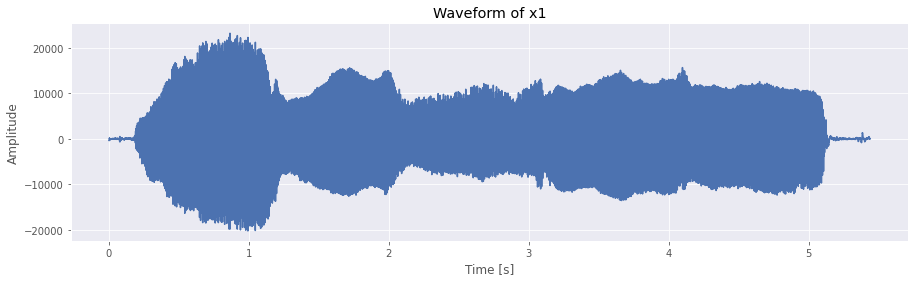

In [5]:
x1.plot_waveform()
x1.listen()

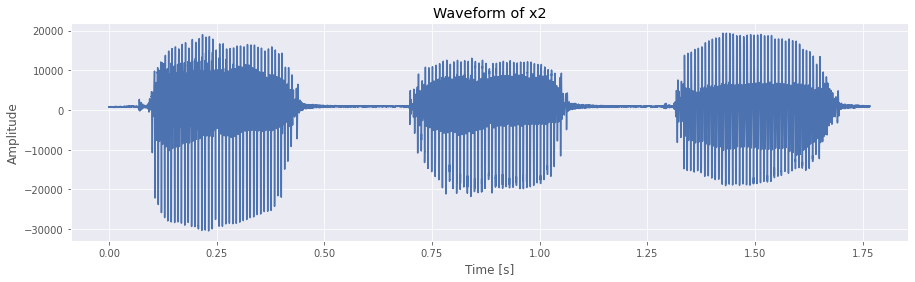

In [6]:
x2.plot_waveform()
x2.listen()

# Exercise 1



In [7]:
from math import ceil

def nextpow2(x):
    assert x>0
    p = ceil(np.log2(x))
    x_ = 2**p
    assert 2**(p-1) < x <= x_
    return p, x_


def period(x, Fs, Pmin=1/300, Pmax=1/80, threshold=0.7):

    x = x - np.nanmean(x)
    N = len(x)

    Nmin = np.ceil(Pmin*Fs).astype(int)
    Nmax = 1 + np.floor(Pmax*Fs).astype(int)
    Nmax = np.min([Nmax, N])

    _, Nfft = nextpow2(2*N-1)
    X = np.fft.fft(x, n=Nfft)
    S = X * np.conj(X) / N
    r = np.real(np.fft.ifft(S))

    rmax = np.max(r[Nmin:Nmax])
    I = np.argmax(r[Nmin:Nmax])
    P = I+Nmin
    corr = (rmax/r[0]) * (N/(N-P))
    voiced = corr > threshold
    if not(voiced):
        P = np.round(10e-3*Fs)

    return P, voiced


def analysis_pitch_marks(self):

    n = len(self.waveform)

    # Initializes the arrays
    ta = np.zeros(n//2)
    voiced = np.full(n//2, False, dtype=np.bool8)
    Pa = np.full(n//2, 10E-3*self.fs)

    i, j = 0, int(2.5*Pa[0])
    while j < n:
        
        # Extracts the sequence x
        start = int(ta[i-1])
        end = start + int(2.5*Pa[i-1])
        x = self.waveform[start:end]

        # Obtains the params
        Pa[i], voiced[i] = period(x, self.fs)
        ta[i] = ta[i-1] + Pa[i]

        # Uptadets j and i
        j = int(ta[i] + 2.5*Pa[i])
        i += 1        

    # Builds the matrix A
    A = np.vstack((ta[:i], voiced[:i], Pa[:i])).astype(np.int32)

    return A

In [8]:
# Adds the method to the signal class
setattr(Signal, "analysis_pitch_marks", analysis_pitch_marks)

In [9]:
x1.analysis_pitch_marks()

array([[  110,   220,   330, ..., 59470, 59580, 59690],
       [    0,     0,     0, ...,     0,     0,     0],
       [  110,   110,   110, ...,   110,   110,   110]])

In [10]:
x2.analysis_pitch_marks()

array([[  160,   320,   480,   640,   800,   960,  1120,  1280,  1440,
         1600,  1718,  1836,  1954,  2075,  2199,  2324,  2450,  2575,
         2701,  2828,  2953,  3079,  3206,  3332,  3459,  3586,  3713,
         3841,  3969,  4097,  4226,  4356,  4485,  4614,  4743,  4872,
         5001,  5131,  5261,  5391,  5521,  5651,  5780,  5908,  6035,
         6161,  6285,  6410,  6533,  6654,  6774,  6943,  7103,  7263,
         7348,  7431,  7516,  7601,  7685,  7769,  7853,  7936,  8019,
         8105,  8189,  8273,  8357,  8442,  8526,  8611,  8771,  8856,
         8939,  9023,  9183,  9343,  9503,  9663,  9823,  9983, 10143,
        10303, 10463, 10623, 10783, 10943, 11103, 11263, 11423, 11583,
        11712, 11843, 11975, 12108, 12241, 12373, 12505, 12638, 12771,
        12903, 13036, 13169, 13301, 13434, 13567, 13699, 13829, 13959,
        14088, 14217, 14346, 14475, 14604, 14732, 14860, 14989, 15118,
        15246, 15374, 15502, 15630, 15758, 15886, 16014, 16142, 16269,
      

# Exercise 2.1

In [11]:
def synthesis(self, B):

    # Obtains params
    fs = self.fs
    waveform = self.waveform
    A = self.analysis_pitch_marks()
    ta, _, Pa = tuple(A)
    ts, n = tuple(B)

    # Defines the returned array y
    y = np.zeros(ts[-1] + Pa[n[-1]])

    for k in range(1, B.shape[1]):

        # Select interval
        start = ta[n[k]] - Pa[n[k]]
        end = ta[n[k]] + Pa[n[k]]

        # Extracts the sequence x
        x = np.copy(waveform[start:end])

        # Windowing of x by a Hann window
        w = hann(len(x))
        x = x*w

        # Performs the OLA
        x_OLA = x
        duration = 2*Pa[n[k]] + 1
        n_pads = np.abs(duration - len(x_OLA))
        n_pads_before = n_pads//2
        n_pads_after = n_pads//2 + 1 if n_pads % 2 else n_pads//2
        if duration >= len(x_OLA):
            x_OLA = np.concatenate((np.zeros(n_pads_before), x_OLA, np.zeros(n_pads_after-1)))
        else:
            x_OLA = x_OLA[n_pads_before:len(x_OLA)-n_pads_after]
        y[ts[k]-Pa[n[k]]:ts[k]+Pa[n[k]]] += x_OLA
    
    return y

In [12]:
# Adds the method to the signal class
setattr(Signal, "synthesis", synthesis)

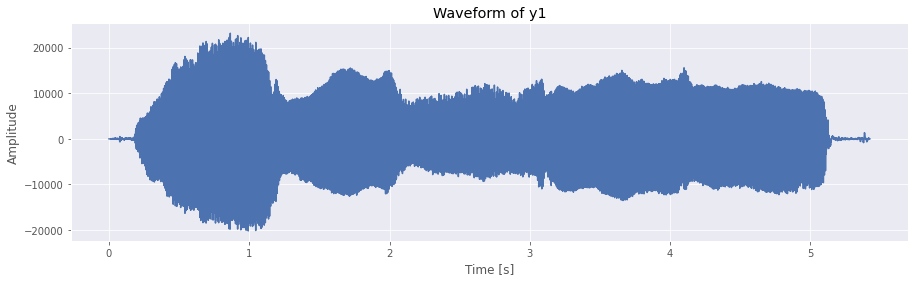

In [13]:
# Defines the no modifications matrixes
A1 = x1.analysis_pitch_marks()
B1 = np.vstack((A1[0, :], np.arange(A1.shape[1])))

# Shows the results
y1 = Signal("y1", waveform=x1.synthesis(B1), fs=x1.fs)
y1.plot_waveform()
y1.listen()

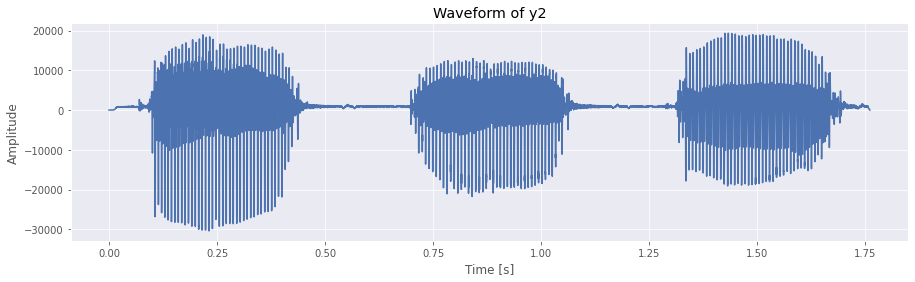

In [14]:
# Defines the no modifications matrixes
A2 = x2.analysis_pitch_marks()
B2 = np.vstack((A2[0, :], np.arange(A2.shape[1])))

# Shows the results
y2 = Signal("y2", waveform=x2.synthesis(B2), fs=x2.fs)
y2.plot_waveform()
y2.listen()

# Exercise 2.2

In [15]:
def change_time_scale(self, alpha):

    # Obtains params
    fs = self.fs
    A = self.analysis_pitch_marks()
    _, __, Pa = tuple(A)

    # Obtains the number of columns of the matrix B
    ncols = int(alpha*(A.shape[1]-1))

    # Sets initial vectors
    ts = np.full(ncols, 1, dtype=np.float32)
    n = np.full(ncols, 1, dtype=np.float32)
 
    for k in range(1, ncols):
        if k+1 < ncols:
            n[k+1] = n[k] + 1/alpha
        ts[k] = ts[k-1] + Pa[int(n[k])]
    
    # Builds the matrix B with integer values of ts and n
    B = np.vstack((ts, n)).astype(np.int32)

    return B

In [16]:
# Adds the method to the signal class
setattr(Signal, "change_time_scale", change_time_scale)

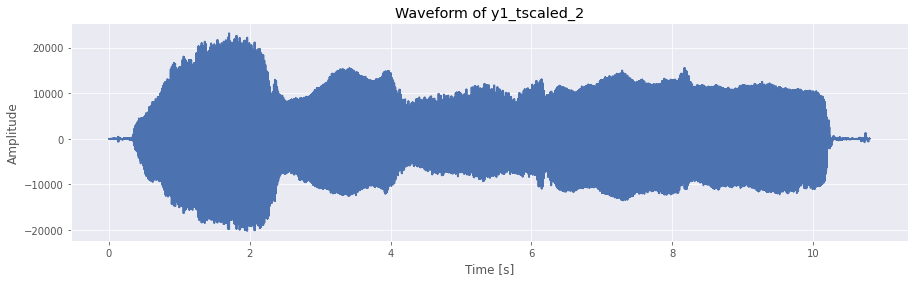

In [17]:
# Defines the time scaler
alpha1 = 2

# Scales the signal x1 in time
B1_tscaled = x1.change_time_scale(alpha1)
y1_tscaled = Signal(f"y1_tscaled_{alpha1}", waveform=x1.synthesis(B1_tscaled), fs=x1.fs)

# Shows results
y1_tscaled.plot_waveform()
y1_tscaled.listen()

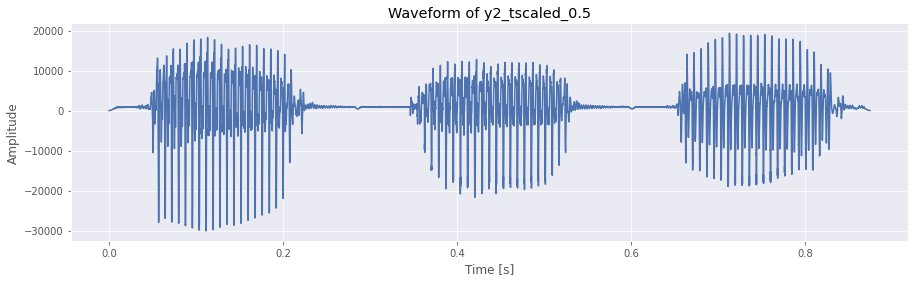

In [18]:
# Defines the time scaler
alpha2 = 0.5

# Scales the signal x2 in time
B2_tscaled = x2.change_time_scale(alpha2)
y2_tscaled = Signal(f"y2_tscaled_{alpha2}", waveform=x2.synthesis(B2_tscaled), fs=x2.fs)

# Shows results
y2_tscaled.plot_waveform()
y2_tscaled.listen()

# Exercise 2.3

In [19]:
def change_pitch_scale(self, beta):

    # Obtains params
    fs = self.fs
    A = self.analysis_pitch_marks()
    _, voiced, Pa = tuple(A)  

    # Obtains the number of columns of the matrix B
    voiced_0 = np.count_nonzero(voiced == 0)   # Number of 0's in voiced
    voiced_1 = np.count_nonzero(voiced == 1)   # Number of 1's in voiced
    ncols = int(voiced_0 + beta*(voiced_1-1))

    # Sets initial vectors
    ts = np.full(ncols, 1, dtype=np.float32)
    n = np.full(ncols, 1, dtype=np.float32)
    scale = np.zeros(ncols)
 
    for k in range(1, ncols):       
        scale[k] = 1/beta if voiced[int(n[k])] else 1
        if k+1 < ncols:
            n[k+1] = n[k] + scale[k]
        ts[k] = ts[k-1] + scale[k]*Pa[int(n[k])]
    
    # Builds the matrix B with integer values of ts and n
    B = np.vstack((ts, n)).astype(np.int32)

    return B

In [20]:
# Adds the method to the signal class
setattr(Signal, "change_pitch_scale", change_pitch_scale)

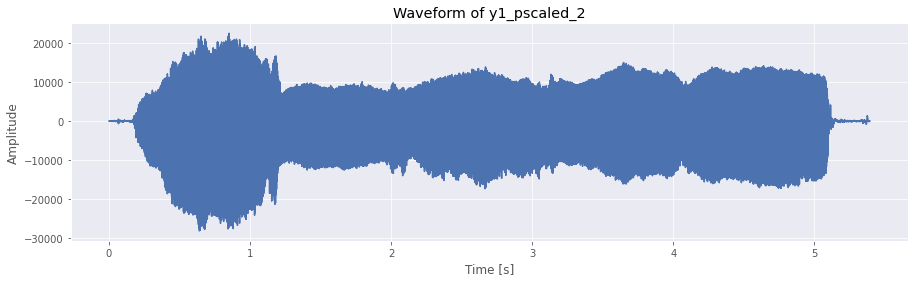

In [21]:
# Defines the pitch scaler
beta1 = 2

# Scales the signal x1 in pitch
B1_pscaled = x1.change_pitch_scale(beta1)
y1_pscaled = Signal(f"y1_pscaled_{beta1}", waveform=x1.synthesis(B1_pscaled), fs=x1.fs)

# Shows results
y1_pscaled.plot_waveform()
y1_pscaled.listen()

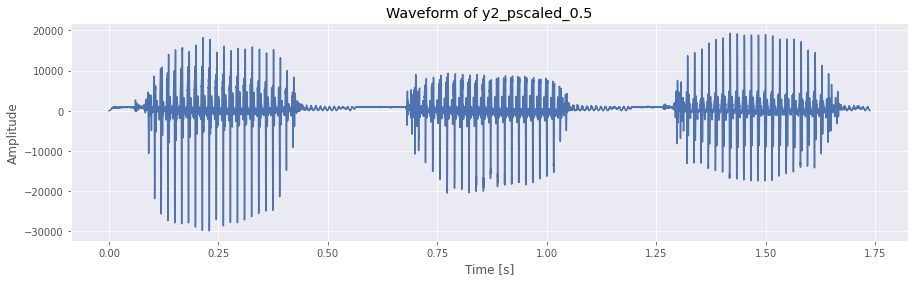

In [22]:
# Defines the pitch scaler
beta2 = 0.5

# Scales the signal x2 in pitch
B2_pscaled = x2.change_pitch_scale(beta2)
y2_pscaled = Signal(f"y2_pscaled_{beta2}", waveform=x2.synthesis(B2_pscaled), fs=x2.fs)

# Shows results
y2_pscaled.plot_waveform()
y2_pscaled.listen()

# Exercise 2.4

In [23]:
def change_both_scales(self, alpha, beta):

    # Obtains params
    fs = self.fs
    A = self.analysis_pitch_marks()
    _, voiced, Pa = tuple(A)   

    # Obtains the number of columns of the matrix B
    voiced_0 = np.count_nonzero(voiced == 0)   # Number of 0's in voiced
    voiced_1 = np.count_nonzero(voiced == 1)   # Number of 1's in voiced
    ncols = int(alpha*(voiced_0 + beta*(voiced_1-1)))

    # Sets initial vectors
    ts = np.full(ncols, 1, dtype=np.float32)
    n = np.full(ncols, 1, dtype=np.float32)
    scale = np.zeros(ncols)
 
    for k in range(1, ncols):
        scale[k] = 1/beta if voiced[int(n[k])] else 1
        if k+1 < ncols:
            n[k+1] = n[k] + scale[k]/alpha
        ts[k] = ts[k-1] + scale[k]*Pa[int(n[k])]
    
    # Builds the matrix B with integer values of ts and n
    B = np.vstack((ts, n)).astype(np.int32)

    return B

In [24]:
# Adds the method to the signal class
setattr(Signal, "change_both_scales", change_both_scales)

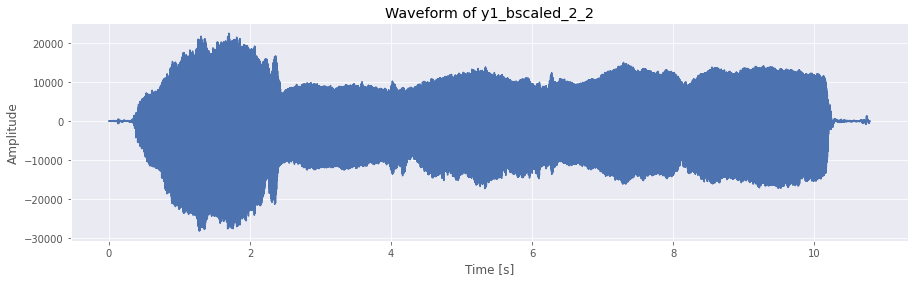

In [25]:
# Defines the time and pitch scalers
alpha1 = 2
beta1 = 2

# Scales the signal x1 in time and pitch
B1_bscaled = x1.change_both_scales(alpha1, beta1)
y1_bscaled = Signal(f"y1_bscaled_{alpha1}_{beta1}", waveform=x1.synthesis(B1_bscaled), fs=x1.fs)

# Shows results
y1_bscaled.plot_waveform()
y1_bscaled.listen()

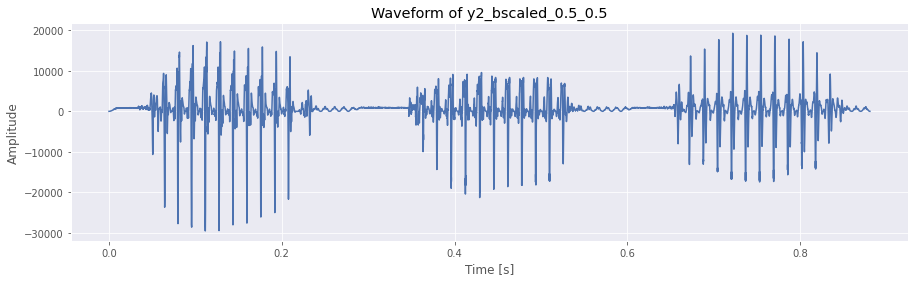

In [26]:
# Defines the time and pitch scalers
alpha2 = 0.5
beta2 = 0.5

# Scales the signal x2 in time and pitch
B2_bscaled = x2.change_both_scales(alpha2, beta2)
y2_bscaled = Signal(f"y2_bscaled_{alpha2}_{beta2}", waveform=x2.synthesis(B2_bscaled), fs=x2.fs)

# Shows results
y2_bscaled.plot_waveform()
y2_bscaled.listen()

# Report

- design
- implementation
- difficulties
- reflections